# Exercise 1: Backtesting with a single ts
Conda environment: `time-series`  
12 Jul 2024

In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from skforecast.datasets import fetch_dataset

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import xgboost as xgb

from feature_engine.creation import CyclicalFeatures
from sktime.transformations.series.date import DateTimeFeatures

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

In [7]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [8]:
# Load the data
data = fetch_dataset(name="website_visits", raw=True)
data

website_visits
--------------
Daily visits to the cienciadedatos.net website registered with the google
analytics service.
Amat Rodrigo, J. (2021). cienciadedatos.net (1.0.0). Zenodo.
https://doi.org/10.5281/zenodo.10006330
Shape of the dataset: (421, 2)


,date,users
0,1/7/20,2324
1,2/7/20,2201
2,3/7/20,2146
3,4/7/20,1666
4,5/7/20,1433
...,...,...
416,21/8/21,1546
417,22/8/21,1393
418,23/8/21,2371
419,24/8/21,2547


In [9]:
# Preprocessing
data["date"] = pd.to_datetime(data["date"], format="%d/%m/%y")
data = data.set_index("date")
data = data.asfreq("D")
data = data.sort_index()
data

,users
date,
2020-07-01,2324
2020-07-02,2201
2020-07-03,2146
2020-07-04,1666
2020-07-05,1433
...,...
2021-08-21,1546
2021-08-22,1393
2021-08-23,2371


In [10]:
data.isnull().any()

users    False
dtype: bool

## 2) EDA

In [11]:
print(len(data))
print(f"start: {data.index.min()}, end: {data.index.max()}")

421
start: 2020-07-01 00:00:00, end: 2021-08-25 00:00:00


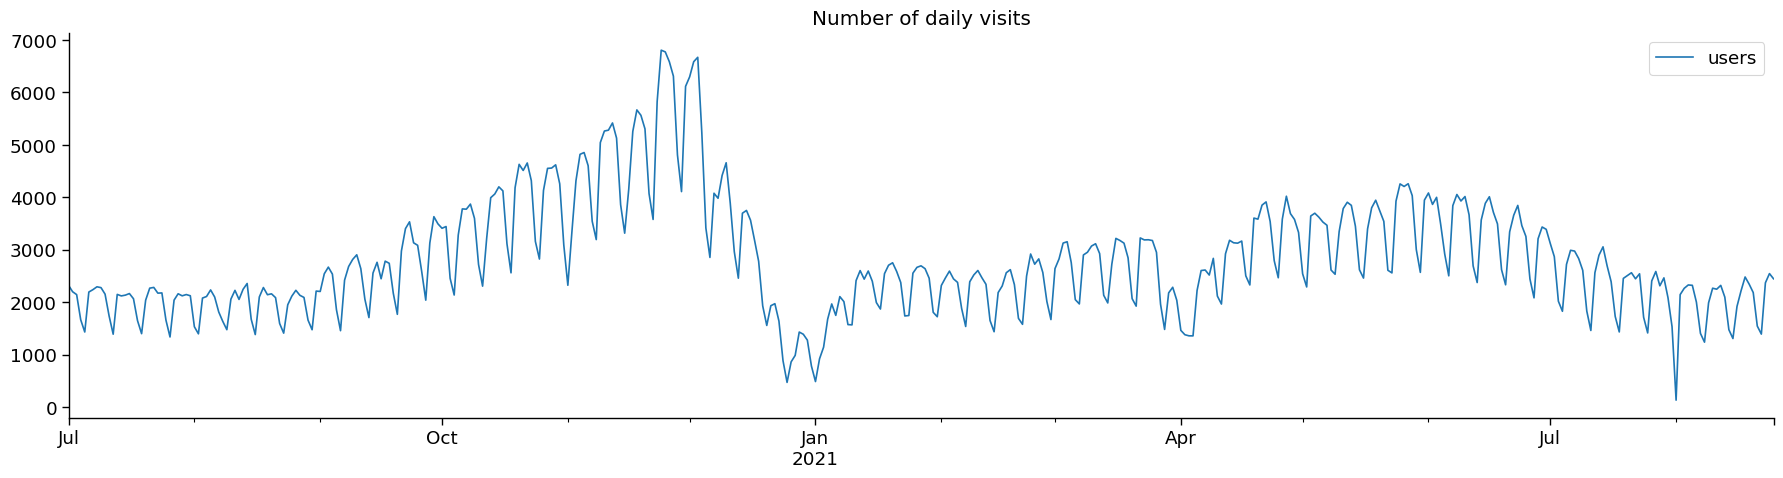

In [13]:
fig, ax = plt.subplots()
data.plot(ax=ax)
ax.set_title("Number of daily visits")

plt.xlabel("")
plt.show()

### 2.1) Weekly seasonality

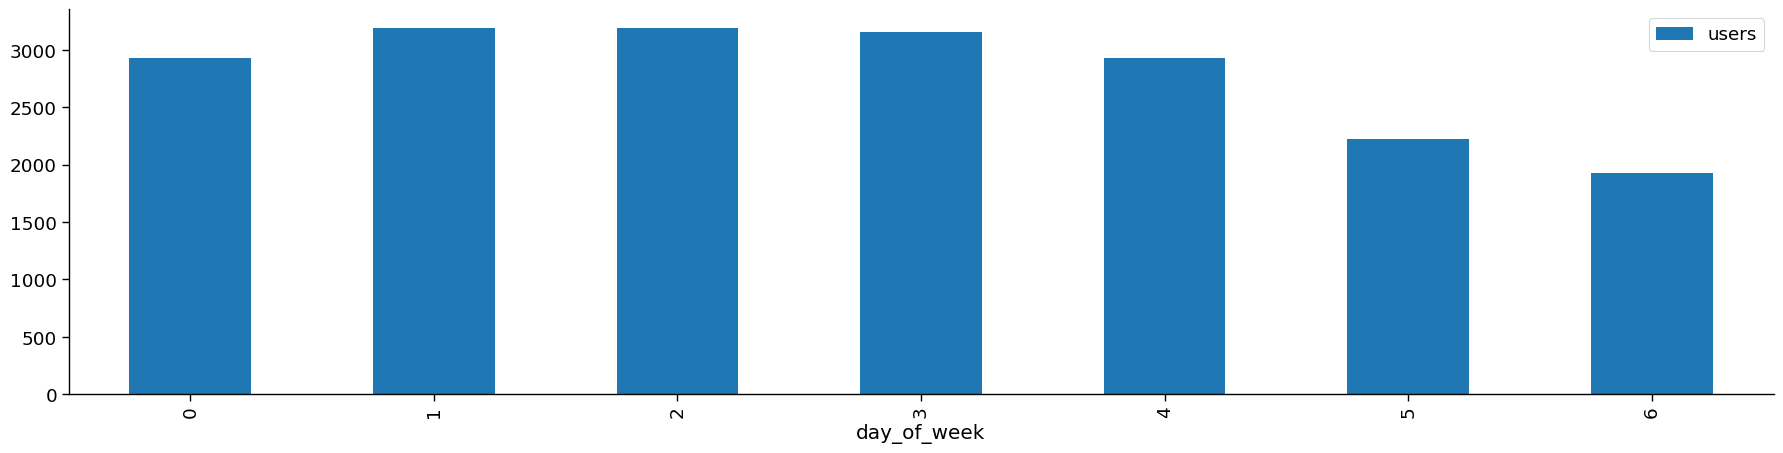

In [15]:
(
    data.assign(day_of_week=lambda df: df.index.weekday)  # Add day of week column
    .groupby("day_of_week")  # Groupby day of week and take the mean
    .mean()
).plot(kind="bar")

plt.show()

### 2.2) Feature engineering

In [20]:
# Day of week
datetime_trafo = DateTimeFeatures(
    manual_selection=["day_of_week"], 
    keep_original_columns=True # Needed to keep `users` column
)

# Cyclical encoding
cyclical_trafo = CyclicalFeatures(
    variables=["day_of_week"], 
    drop_original=False # Needed to keep `users` column
) 

# Let's create a pipeline to make our exogenous features
feature_eng_pipeline = Pipeline(
    steps=[
        ("datetime_features", datetime_trafo), 
        ("cyclical_features", cyclical_trafo),
    ]
)

feature_eng_pipeline

Pipeline(steps=[('datetime_features',
                 DateTimeFeatures(keep_original_columns=True, manual_selection=['day_of_week'])),
                ('cyclical_features',
                 CyclicalFeatures(variables=['day_of_week']))])

In [21]:
data = feature_eng_pipeline.fit_transform(data)
data

,users,day_of_week,day_of_week_sin,day_of_week_cos
date,,,,
2020-07-01,2324,2,0.8660,-0.5000
2020-07-02,2201,3,0.0000,-1.0000
2020-07-03,2146,4,-0.8660,-0.5000
2020-07-04,1666,5,-0.8660,0.5000
2020-07-05,1433,6,-0.0000,1.0000
...,...,...,...,...
2021-08-21,1546,5,-0.8660,0.5000
2021-08-22,1393,6,-0.0000,1.0000
2021-08-23,2371,0,0.0000,1.0000


## 3) Forecasting

### 3.1) Model definition

In [28]:
# Define the lags to use
lags = 7  # Use all the lags up to 7 as features

# Create linear forecaster
linear_forecaster = ForecasterAutoreg(
    regressor=Ridge(alpha=1),
    lags=lags,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# # Create LightGBM forecaster
# params_lgbm = {
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 10,
#     "random_state": 123,
#     "verbose": -1,
# }

# Create XGBoost forecaster
xgboost_params = {
    "verbosity": 0, "booster": "gbtree", "random_state": 123
}

xgboost_forecaster = ForecasterAutoreg(
    regressor=xgb.XGBRegressor(**xgboost_params),
    lags=lags,
)

### 3.2) Backtesting with intermittent refitting

In [30]:
# Linear forecaster backtesting
num_refit = 7
HORIZON = 7

metric_linear, predictions_linear = backtesting_forecaster(
    forecaster=linear_forecaster,
    y=data["users"],
    exog=data[["day_of_week", "day_of_week_sin", "day_of_week_cos"]],
    metric=["mean_squared_error", "mean_absolute_percentage_error"],
    initial_train_size=30,
    allow_incomplete_fold=True,
    fixed_train_size=False,
    steps=HORIZON,
    refit=num_refit,
    verbose=True,
    show_progress=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 391
    Number of folds: 56
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-07-31 00:00:00 -- 2020-08-06 00:00:00  (n=7)
Fold: 1
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-08-07 00:00:00 -- 2020-08-13 00:00:00  (n=7)
Fold: 2
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-08-14 00:00:00 -- 2020-08-20 00:00:00  (n=7)
Fold: 3
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-08-21 00:00:00 -- 2020-08-27 00:00:00  (n=7)
Fold: 4
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    V

  0%|          | 0/56 [00:00<?, ?it/s]

In [34]:
# LightGBM backtesting
metric_xgboost, predictions_xgboost = backtesting_forecaster(
    forecaster=xgboost_forecaster,
    y=data["users"],
    exog=data[["day_of_week", "day_of_week_sin", "day_of_week_cos"]],
    metric=["mean_squared_error", "mean_absolute_percentage_error"],
    initial_train_size=30,
    allow_incomplete_fold=True,
    fixed_train_size=False,
    steps=7,
    refit=7,
    verbose=True,
    show_progress=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 391
    Number of folds: 56
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-07-31 00:00:00 -- 2020-08-06 00:00:00  (n=7)
Fold: 1
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-08-07 00:00:00 -- 2020-08-13 00:00:00  (n=7)
Fold: 2
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-08-14 00:00:00 -- 2020-08-20 00:00:00  (n=7)
Fold: 3
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-08-21 00:00:00 -- 2020-08-27 00:00:00  (n=7)
Fold: 4
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    V

  0%|          | 0/56 [00:00<?, ?it/s]

In [36]:
print(f"MSE:{metric_linear[0]: ,.4f}, MAPE:{metric_linear[1]: ,.4f}")
print(f"MSE:{metric_xgboost[0]: ,.4f}, MAPE:{metric_xgboost[1]: ,.4f}")

MSE: 271,790.9800, MAPE: 0.1521
MSE: 518,854.3892, MAPE: 0.2045


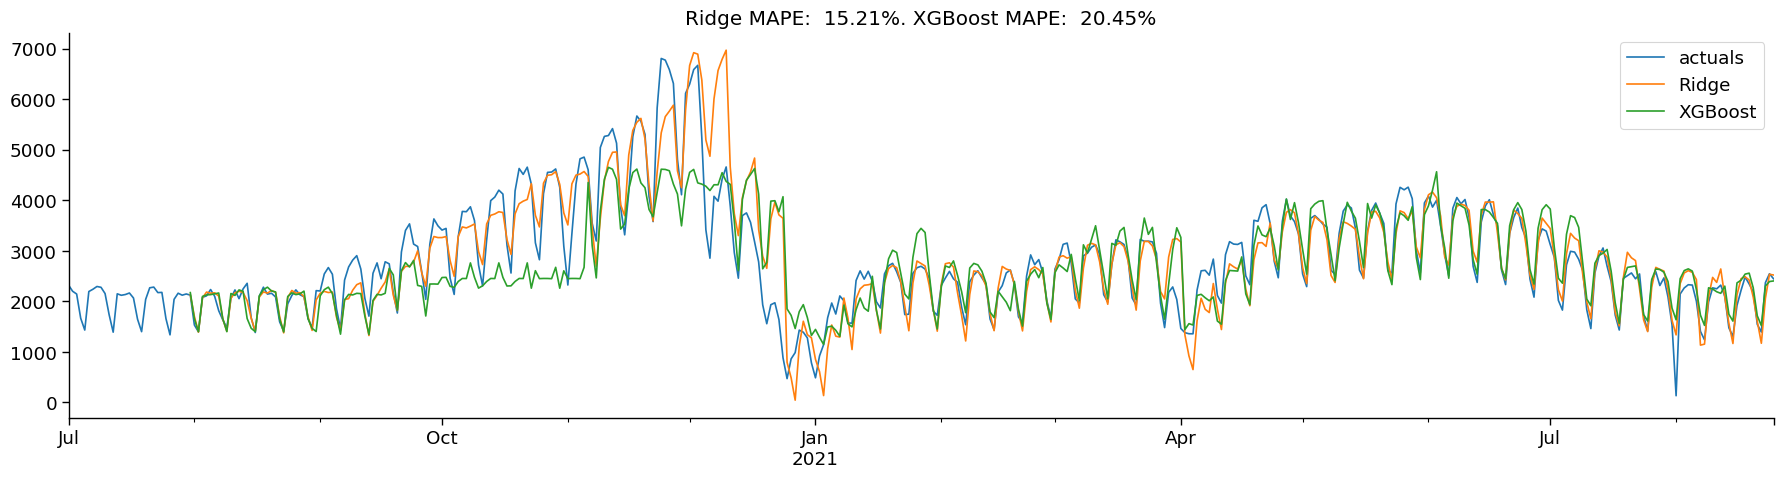

In [43]:
fig, ax = plt.subplots()

data["users"].plot(ax=ax, label="actuals")
predictions_linear["pred"].plot(ax=ax, label="Ridge")
predictions_xgboost["pred"].plot(ax=ax, label="XGBoost")

ax.legend()

plt.title(f"Ridge MAPE: {metric_linear[1]: .2%}. XGBoost MAPE: {metric_xgboost[1]: .2%}")
plt.xlabel("")
plt.show()

The performance of the lightgbm **might** be improved if we were to use:
- More features using feature engineering
- Hyperparameter tuning
- More data (it required more data as it is a more complex model)
- A method to handle the trend in the data

Typically tree based models will do best when working with a large number of multiple time series. Also they struggle when there is a lot of trend in the data. De-trending the data first could help with this.